In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

In [ ]:
# ===============================
# STEP 1: DATASET PREPARATION
# ===============================
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Add channel dimension
x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)

print("Training data shape:", x_train.shape)
print("Testing data shape:", x_test.shape)


Training data shape: (60000, 28, 28, 1)
Testing data shape: (10000, 28, 28, 1)


In [ ]:
latent_dim = 2   # keep 2 for latent space visualization


In [ ]:
# -------- ENCODER --------
encoder_inputs = layers.Input(shape=(28, 28, 1))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Reparameterization Trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 784)       │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │    200,960 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     32,896 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        258 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        258 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 234,372 (915.52 KB)

 Trainable params: 234,372 (915.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# -------- DECODER --------
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(128, activation="relu")(decoder_inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(28 * 28, activation="sigmoid")(x)
decoder_outputs = layers.Reshape((28, 28, 1))(x)

decoder = models.Model(decoder_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 784)            │       201,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 234,896 (917.56 KB)

 Trainable params: 234,896 (917.56 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ===============================
# STEP 3 & 4: VAE MODEL + LOSS
# ===============================
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    def compute_loss(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        # Reconstruction loss
        recon_loss = tf.reduce_mean(
            tf.reduce_sum(
                tf.keras.losses.binary_crossentropy(data, reconstruction),
                axis=(1, 2)
            )
        )

        # KL divergence
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                axis=1
            )
        )

        total_loss = recon_loss + kl_loss
        return total_loss, recon_loss, kl_loss

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            total_loss, recon_loss, kl_loss = self.compute_loss(data)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": recon_loss,
            "kl_loss": kl_loss,
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        total_loss, recon_loss, kl_loss = self.compute_loss(data)

        return {
            "loss": total_loss,
            "reconstruction_loss": recon_loss,
            "kl_loss": kl_loss,
        }


In [ ]:
# ===============================
# STEP 4: TRAIN THE VAE
# ===============================
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

history = vae.fit(
    x_train,
    epochs=20,
    batch_size=128,
    validation_data=(x_test, None)
)


Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - kl_loss: 5.5213 - loss: 193.0100 - reconstruction_loss: 187.4887 - val_kl_loss: 5.3047 - val_loss: 174.1976 - val_reconstruction_loss: 168.8929
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - kl_loss: 4.8975 - loss: 165.5052 - reconstruction_loss: 160.6077 - val_kl_loss: 5.1488 - val_loss: 161.9410 - val_reconstruction_loss: 156.7922
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 5.1882 - loss: 160.8400 - reconstruction_loss: 155.6518 - val_kl_loss: 5.3158 - val_loss: 159.5149 - val_reconstruction_loss: 154.1991
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 5.4545 - loss: 157.5181 - reconstruction_loss: 152.0636 - val_kl_loss: 5.7667 - val_loss: 154.6864 - val_reconstruction_loss: 148.9197
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 5.6142 - loss: 155.1158 - reconstruction_loss: 149.5016 - val_kl_loss: 5.8019 - val_loss: 152.6224 - val_reconstruction_loss: 146.8205
Epoch 6/20

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


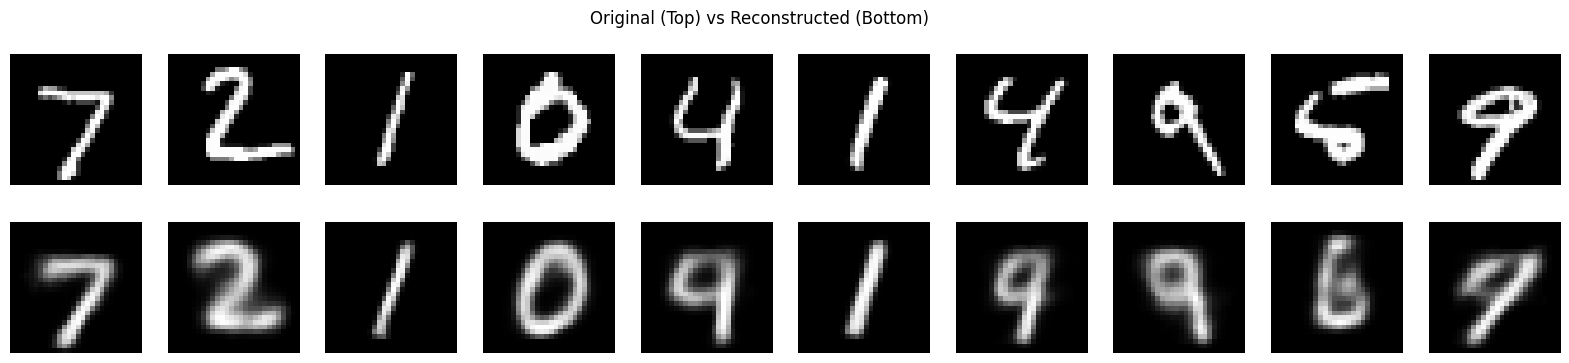

In [ ]:
# ===============================
# STEP 5: RECONSTRUCTED IMAGES
# ===============================
decoded_imgs = vae.predict(x_test[:10])

plt.figure(figsize=(20, 4))
for i in range(10):
    # Original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, 10, i + 11)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
    plt.axis("off")

plt.suptitle("Original (Top) vs Reconstructed (Bottom)")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


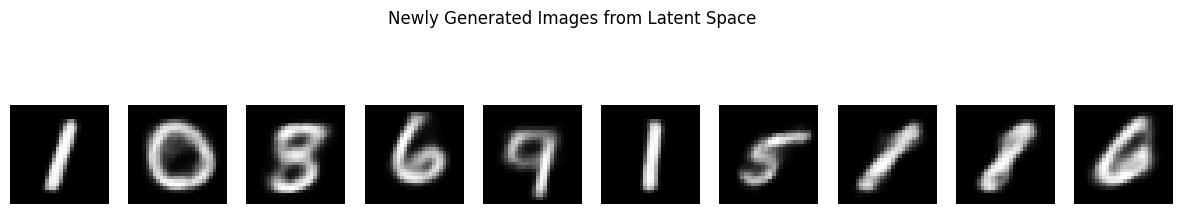

In [ ]:
# ===============================
# STEP 6: NEWLY GENERATED IMAGES
# ===============================
n = 10
z_samples = np.random.normal(0, 1, (n, latent_dim))
generated_images = decoder.predict(z_samples)

plt.figure(figsize=(15, 3))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(generated_images[i].reshape(28, 28), cmap="gray")
    plt.axis("off")

plt.suptitle("Newly Generated Images from Latent Space")
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


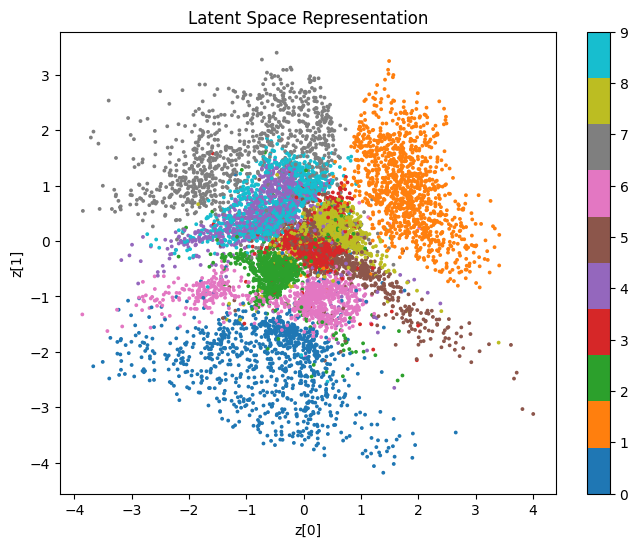

In [ ]:
# ===============================
# STEP 7: LATENT SPACE VISUALIZATION
# ===============================
z_mean, _, _ = encoder.predict(x_test)

plt.figure(figsize=(8, 6))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap="tab10", s=3)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("Latent Space Representation")
plt.show()


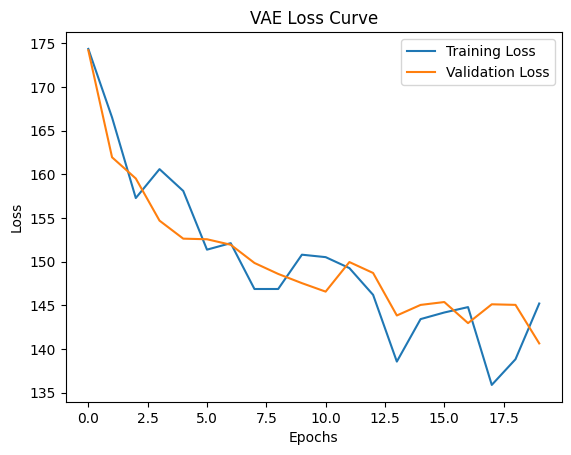

In [ ]:
# ===============================
# STEP 8: LOSS CURVES
# ===============================
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("VAE Loss Curve")
plt.show()
